In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Normalize, v2
from torchvision import tv_tensors
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
def lin_indices(original_length, subsampled_length):
    indices = np.linspace(0, original_length - 1, subsampled_length + 1, dtype=int)
    return indices[1:]

def uniform_biosensor(biosensor):
    indices = lin_indices(biosensor.shape[0], 8)
    # if self.input_scaling == False:
    return biosensor[indices]
    # downsampled_bio = biosensor[indices]
    # upscaled = torch.nn.functional.interpolate(downsampled_bio.unsqueeze(0), size=(self.mask_size, self.mask_size), mode=self.upscale_mode).squeeze(0)
    # return upscaled
    
def uniform_mask(mask, centers):
    interpolated_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(320, 320), mode='nearest').squeeze(0).squeeze(0).byte()
    
    # x_scale = mask.shape[0] / 80
    # y_scale = mask.shape[1] / 80
    
    # scaled_centers = centers / [x_scale, y_scale]

    # # Add the cell centers to the mask
    # indices = np.transpose(scaled_centers.astype(int))
    # interpolated_mask[indices[0], indices[1]] = True
    
    return interpolated_mask

In [3]:
"""
Copyright © 2023 Howard Hughes Medical Institute, Authored by Carsen Stringer and Marius Pachitariu.
"""

from scipy.ndimage import find_objects
from numba import njit, prange, float32, int32

import torch.nn.functional as F

# @njit("(float64[:], int32[:], int32[:], int32, int32, int32, int32)", nogil=True)
# def _extend_centers(T, y, x, ymed, xmed, Lx, niter):
#     """Run diffusion from the center of the mask on the mask pixels.

#     Args:
#         T (numpy.ndarray): Array of shape (Ly * Lx) where diffusion is run.
#         y (numpy.ndarray): Array of y-coordinates of pixels inside the mask.
#         x (numpy.ndarray): Array of x-coordinates of pixels inside the mask.
#         ymed (int): Center of the mask in the y-coordinate.
#         xmed (int): Center of the mask in the x-coordinate.
#         Lx (int): Size of the x-dimension of the masks.
#         niter (int): Number of iterations to run diffusion.

#     Returns:
#         numpy.ndarray: Array of shape (Ly * Lx) representing the amount of diffused particles at each pixel.
#     """
#     for t in range(niter):
#         T[ymed * Lx + xmed] += 1
#         T[y * Lx +
#           x] = 1 / 9. * (T[y * Lx + x] + T[(y - 1) * Lx + x] + T[(y + 1) * Lx + x] +
#                          T[y * Lx + x - 1] + T[y * Lx + x + 1] +
#                          T[(y - 1) * Lx + x - 1] + T[(y - 1) * Lx + x + 1] +
#                          T[(y + 1) * Lx + x - 1] + T[(y + 1) * Lx + x + 1])
#     return T


def _extend_centers_gpu(neighbors, meds, isneighbor, shape, n_iter=200, device=None):
    """Runs diffusion on GPU to generate flows for training images or quality control.

    Args:
        neighbors (torch.Tensor): 9 x pixels in masks.
        meds (torch.Tensor): Mask centers.
        isneighbor (torch.Tensor): Valid neighbor boolean 9 x pixels.
        shape (tuple): Shape of the tensor.
        n_iter (int, optional): Number of iterations. Defaults to 200.
        device (torch.device, optional): Device to run the computation on. Defaults to torch.device("cuda").

    Returns:
        torch.Tensor: Generated flows.

    """
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else None
    
    
    if device.type == "mps":
        T = torch.zeros(shape, dtype=torch.float, device=device)
    else:
        T = torch.zeros(shape, dtype=torch.double, device=device)
    for i in range(n_iter):
        T[tuple(meds.T)] += 1
        Tneigh = T[tuple(neighbors)]
        Tneigh *= isneighbor
        T[tuple(neighbors[:, 0])] = Tneigh.mean(axis=0)
    del meds, isneighbor, Tneigh

    if T.ndim == 2:
        grads = T[neighbors[0, [2, 1, 4, 3]], neighbors[1, [2, 1, 4, 3]]]
        del neighbors
        dy = grads[0] - grads[1]
        dx = grads[2] - grads[3]
        del grads
        mu_torch = np.stack((dy.cpu().squeeze(0), dx.cpu().squeeze(0)), axis=-2)
    else:
        grads = T[tuple(neighbors[:, 1:])]
        del neighbors
        dz = grads[0] - grads[1]
        dy = grads[2] - grads[3]
        dx = grads[4] - grads[5]
        del grads
        mu_torch = np.stack(
            (dz.cpu().squeeze(0), dy.cpu().squeeze(0), dx.cpu().squeeze(0)), axis=-2)
    return mu_torch


@njit(nogil=True)
def get_centers(masks, slices):
    """
    Get the centers of the masks and their extents.

    Args:
        masks (ndarray): The labeled masks.
        slices (ndarray): The slices of the masks.

    Returns:
        tuple containing
            - centers (ndarray): The centers of the masks.
            - ext (ndarray): The extents of the masks.
    """
    centers = np.zeros((len(slices), 2), "int32")
    ext = np.zeros((len(slices),), "int32")
    for p in prange(len(slices)):
        si = slices[p]
        i = si[0]
        sr, sc = si[1:3], si[3:5]
        # find center in slice around mask
        yi, xi = np.nonzero(masks[sr[0]:sr[-1], sc[0]:sc[-1]] == (i + 1))
        ymed = yi.mean()
        xmed = xi.mean()
        # center is closest point to (ymed, xmed) within mask
        imin = ((xi - xmed)**2 + (yi - ymed)**2).argmin()
        ymed = yi[imin] + sr[0]
        xmed = xi[imin] + sc[0]
        centers[p] = np.array([ymed, xmed])
        ext[p] = (sr[-1] - sr[0]) + (sc[-1] - sc[0]) + 2
    return centers, ext


def masks_to_flows_gpu(masks, device=None, niter=None):
    """Convert masks to flows using diffusion from center pixel.

    Center of masks where diffusion starts is defined using COM.

    Args:
        masks (int, 2D or 3D array): Labelled masks. 0=NO masks; 1,2,...=mask labels.

    Returns:
        tuple containing
            - mu (float, 3D or 4D array): Flows in Y = mu[-2], flows in X = mu[-1].
                If masks are 3D, flows in Z = mu[0].
            - meds_p (float, 2D or 3D array): cell centers
    """
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else None

    Ly0, Lx0 = masks.shape
    Ly, Lx = Ly0 + 2, Lx0 + 2

    masks_padded = torch.from_numpy(masks.astype("int64")).to(device)
    masks_padded = F.pad(masks_padded, (1, 1, 1, 1))

    ### get mask pixel neighbors
    y, x = torch.nonzero(masks_padded, as_tuple=True)
    neighborsY = torch.stack((y, y - 1, y + 1, y, y, y - 1, y - 1, y + 1, y + 1), dim=0)
    neighborsX = torch.stack((x, x, x, x - 1, x + 1, x - 1, x + 1, x - 1, x + 1), dim=0)
    neighbors = torch.stack((neighborsY, neighborsX), dim=0)
    neighbor_masks = masks_padded[tuple(neighbors)]
    isneighbor = neighbor_masks == neighbor_masks[0]

    ### get center-of-mass within cell
    slices = find_objects(masks)
    # turn slices into array
    slices = np.array([
        np.array([i, si[0].start, si[0].stop, si[1].start, si[1].stop])
        for i, si in enumerate(slices)
        if si is not None
    ])
    centers, ext = get_centers(masks, slices)
    meds_p = torch.from_numpy(centers).to(device).long()
    meds_p += 1  # for padding

    ### run diffusion
    n_iter = 2 * ext.max() if niter is None else niter
    shape = masks_padded.shape
    mu = _extend_centers_gpu(neighbors, meds_p, isneighbor, shape, n_iter=n_iter,
                             device=device)

    # new normalization
    mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)
    #mu /= (1e-20 + (mu**2).sum(axis=0)**0.5)

    # put into original image
    mu0 = np.zeros((2, Ly0, Lx0))
    mu0[:, y.cpu().numpy() - 1, x.cpu().numpy() - 1] = mu

    return mu0, meds_p.cpu().numpy() - 1

In [10]:
data = np.load('C:/onlab_git/Onlab/data_with_centers/20.npz')
bio = uniform_biosensor(torch.from_numpy(data['biosensor'].astype(np.float32)))
mask = uniform_mask(torch.from_numpy(data['mask'].astype(bool)), data['cell_centers'])
device = torch.device('cuda')
flows, centers = masks_to_flows_gpu(data['mask'], device)
print(flows.shape)

(2, 4105, 4105)


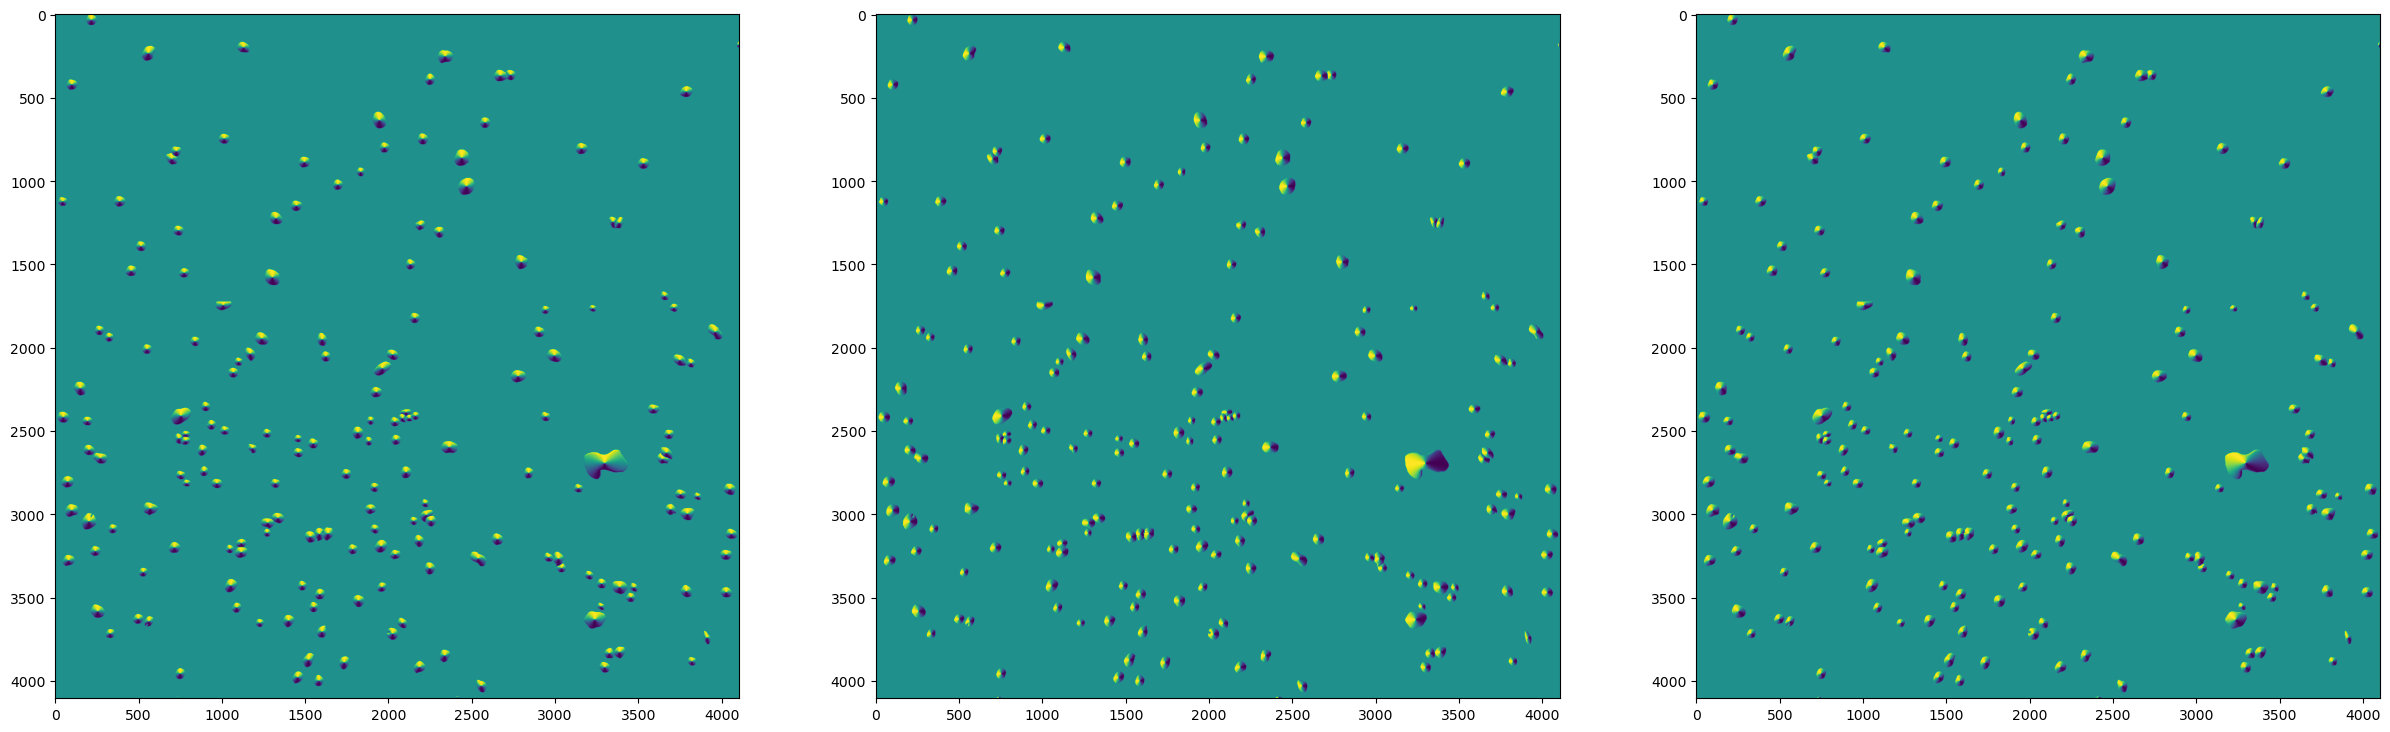

In [11]:
plt.figure(figsize=(30, 10))
plt.subplot(131)
plt.imshow(flows[0])
plt.subplot(132)
plt.imshow(flows[1])
plt.subplot(133)
plt.imshow(flows[0] + flows[1])
plt.show()

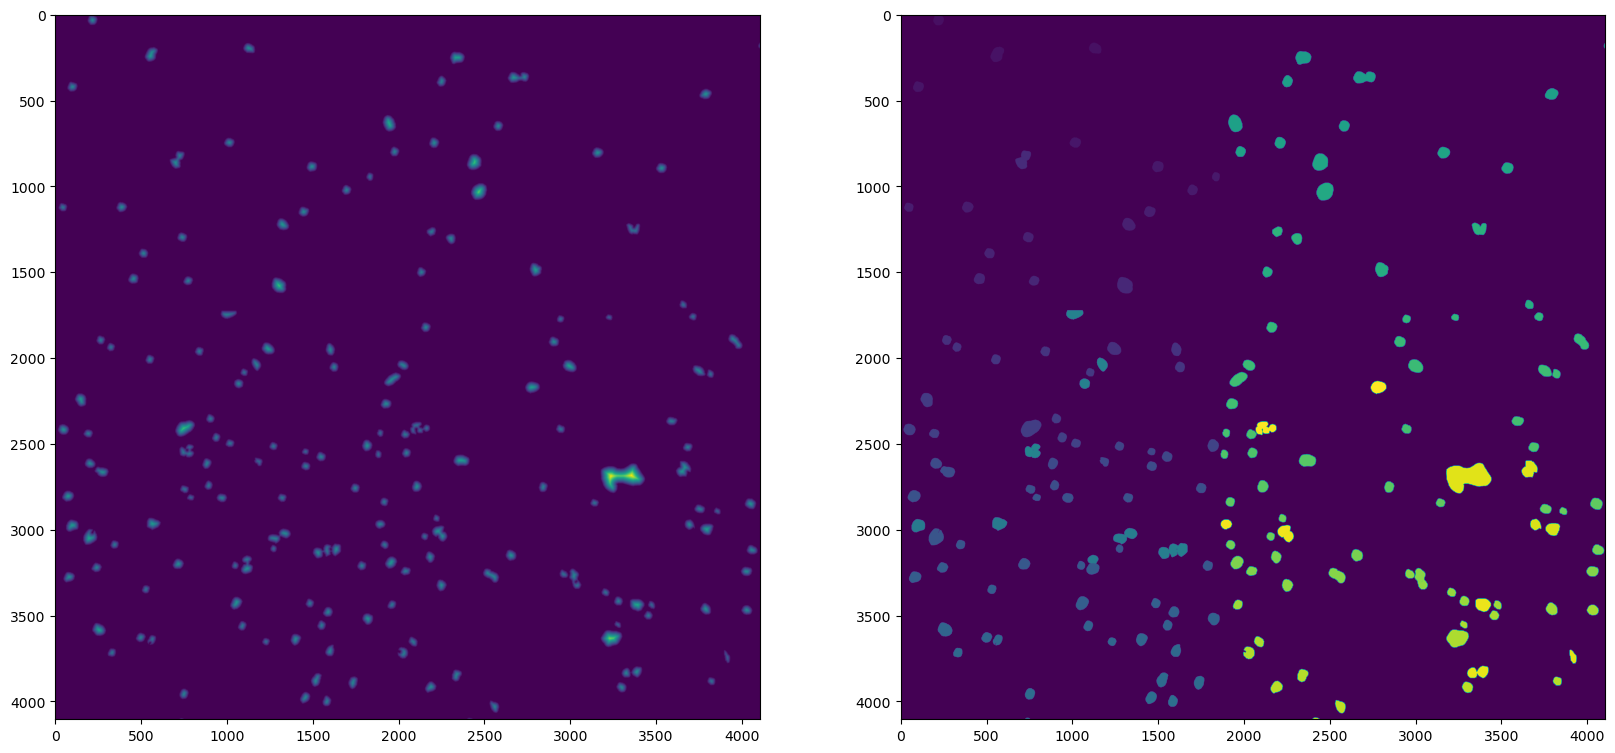

In [8]:
from scipy import ndimage

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(ndimage.distance_transform_edt(data['mask']))
plt.subplot(122)
plt.imshow(data['mask'])
plt.show()